In [1]:
import pandas as pd 
import re
import string
import json

# parsing
from bs4 import BeautifulSoup
import codecs

import numpy as np
import matplotlib.pyplot as plt

import requests

# import seaborn as sns


import nltk
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
import pymorphy2
from tqdm import tqdm

from collections import Counter

In [2]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV
from sklearn.metrics import pairwise_distances
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [4]:
#nltk.download('punkt')

## Prepare data

In [5]:
def is_ru_alpha(tested_string):
    match = re.match("^[а-яА-Я]+$", tested_string)
    return match is not None

In [6]:
def dump_to_file(path, file_name, my_list):
    with open(path + '/' + file_name + '.txt', 'w') as f:
        for item in my_list:
            f.write("%s\n" % item)

In [7]:
def normalize_tokens(tokens):
    morph = pymorphy2.MorphAnalyzer()
    return [morph.parse(tok)[0].normal_form for tok in tokens]

In [8]:
def remove_stopwords(tokens, stopwords=None, min_length=4):
    if not stopwords:
        return tokens
    stopwords = set(stopwords)
    tokens = [tok
              for tok in tokens
              if tok not in stopwords and len(tok) >= min_length]
    return tokens

In [9]:
def tokenize_n_lemmatize(text, stopwords=True, normalize=True):
    if normalize:
        words = normalize_tokens(text)
    if stopwords:
        words = remove_stopwords(words, stopwords)
    return words

In [10]:
def get_url_text(url, encoding='utf-8', to_lower=True):
    url = str(url)
    if url.startswith('http'):
        r = requests.get(url)
        if not r.ok:
            r.raise_for_status()
        return r.text.lower() if to_lower else r.text
    elif os.path.exists(url):
        with open(url, encoding=encoding) as f:
            return f.read().lower() if to_lower else f.read()
    else:
        raise Exception('parameter [url] can be either URL or a filename')

In [11]:
url_stopwords_ru = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt"
stopwords_ru = get_url_text(url_stopwords_ru).splitlines()

In [12]:
def pre_processor():
    pass

## Read corpus

In [13]:
with open('corpus.txt', 'r', encoding='utf-8') as file:
    json_corp = file.read()
    corpus = json.loads(json_corp)

## Bulid vectorizer

In [50]:
iter_corpus = list(corpus.keys())
len(iter_corpus)

915849

In [51]:
vectorizer = CountVectorizer(vocabulary=iter_corpus)

In [52]:
_ = vectorizer.transform(['привет как']).toarray()
_.shape

(1, 915849)

## Vectorize pages

In [13]:
def get_page_words(page_num):
    load_path='content/'
    filetail = '.dat'
    with codecs.open(load_path + str(page_num) + filetail, 'r', 'utf-8') as f:
        content = BeautifulSoup(f, 'lxml').text
        content = re.sub(r'\n', ' ', content)
        content = re.sub(r'\t', ' ', content)

    text = set()
    for word in content.split():
        word = word.translate(str.maketrans(' ', ' ', string.punctuation))
        text.add(word)

    words = tokenize_n_lemmatize(list(text), stopwords=stopwords_ru)
    return words

In [14]:
def vectorize_pages(start_page=1, finish_page=28027):
        
    _words = get_page_words(start_page)
    _page_text = ' '.join(_words)
    result = vectorizer.transform([_page_text]).toarray()
        
    with tqdm(total=finish_page-start_page-1) as pbar:If ‘filename’, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.
        for page_num in range(start_page+1, finish_page): # 1, 28027
            words = get_page_words(page_num)
            page_text = ' '.join(words)
            page_vect = vectorizer.transform([page_text]).toarray()
            
            result = np.vstack((result, page_vect))
            
            pbar.update(1)
    
    return resultIf ‘filename’, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.

SyntaxError: invalid character in identifier (<ipython-input-14-8c796da39e59>, line 7)

In [66]:
res1_5000 = vectorize_pages(1, 5000)

 11%|█▏        | 564/4998 [22:49<2:59:28,  2.43s/it] 


KeyboardInterrupt: 

In [ ]:
def vectorize_pages(start_page=1, finish_page=28027):
        
    _words = get_page_words(start_page)
    _page_text = ' '.join(_words)
    result = vectorizer.transform([_page_text]).toarray()
        
    with tqdm(total=finish_page-start_page-1) as pbar:
        for page_num in range(start_page+1, finish_page): # 1, 28027
            words = get_page_words(page_num)
            page_text = ' '.join(words)
            page_vect = vectorizer.transform([page_text]).toarray()
            
            result = np.vstack((result, page_vect))
            
            pbar.update(1)
    
    return result

## Rewrite files

In [171]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [14]:
def rewrite_file(page_num):
    load_path='content/'
    filetail = '.dat'
    with codecs.open(load_path + str(page_num) + filetail, 'r', 'utf-8') as f:
        content = BeautifulSoup(f, 'lxml').text
        content = re.sub(r'\n', ' ', content)
        content = re.sub(r'\t', ' ', content)

    text = []
    for word in content.split():
        word = word.translate(str.maketrans(' ', ' ', string.punctuation))
        text.append(word)
    words = tokenize_n_lemmatize(text, stopwords=stopwords_ru)
    
    save_path='/media/dmitry/EXT SSD/clean_content/'
    save_filetail = '.txt'
    with open(save_path + 'text_' + str(page_num) + save_filetail, 'w') as f:
        f.write(' '.join(words))

In [172]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        groups_train.append(new_group)
groups_train = np.array(groups_train)
print(groups_train.shape)

(11690,)


In [15]:
def rewr_files(start_page=1, finish_page=28027):
    with tqdm(total=finish_page-start_page) as pbar:
        for page_num in range(start_page, finish_page): # 1, 28027
            rewrite_file(page_num)
            pbar.update(1)
    

In [14]:
#rewr_files(100, 1001)

100%|██████████| 901/901 [29:14<00:00,  1.95s/it]  


In [20]:
#rewr_files(3010, 4000)

100%|██████████| 990/990 [30:59<00:00,  1.88s/it]  


In [21]:
#rewr_files(4000, 20000)

100%|██████████| 16000/16000 [9:05:04<00:00,  2.04s/it]   


In [22]:
#rewr_files(20000, 24000)

100%|██████████| 4000/4000 [2:00:41<00:00,  1.81s/it]  


In [39]:
#rewr_files(24000, 28027)

100%|██████████| 4027/4027 [2:17:28<00:00,  2.05s/it]  


In [53]:
#rewr_files(28026, 28027)

100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


## Fitting tf-idf vectorizer

In [154]:
#save_path='/media/dmitry/EXT SSD/clean_content/'
#save_filetail = '.txt'
with open('/media/dmitry/EXT SSD/clean_content/text_0.txt', 'w') as f:
    f.write('')

In [196]:
file_list = [f'/media/dmitry/EXT SSD/clean_content/text_{_i}.txt' for _i in range(0, 28027)]

In [197]:
tfidf_corpus = {key:val for key, val in corpus.items() if val>1}

In [198]:
tfidf_corpus = list(tfidf_corpus.keys())

In [199]:
len(tfidf_corpus)

915849

In [220]:
vectorizer = TfidfVectorizer(input='filename', vocabulary=tfidf_corpus, max_df=0.25)

In [221]:
doc_tfidf = vectorizer.fit_transform(file_list)

In [222]:
doc_tfidf.shape

(28027, 915849)

### Create X_train & X_test

In [223]:
df = pd.read_csv('train_groups.csv')
groups = df.groupby('group_id')
global_index = 0
X = np.empty((df.shape[0], 20), dtype=float)
y = np.empty(df.shape[0], dtype=float)
for group_id, group_index in groups.groups.items():
    size_of_group = group_index.size
    group = (df.iloc[group_index])
    for index, distances in enumerate(pairwise_distances(doc_tfidf[group.doc_id], metric='cosine')):
        X[global_index + index] = sorted(distances)[1:21]
    y[global_index:size_of_group+global_index] = group.target
    global_index += size_of_group
X.shape, y.shape

((11690, 20), (11690,))

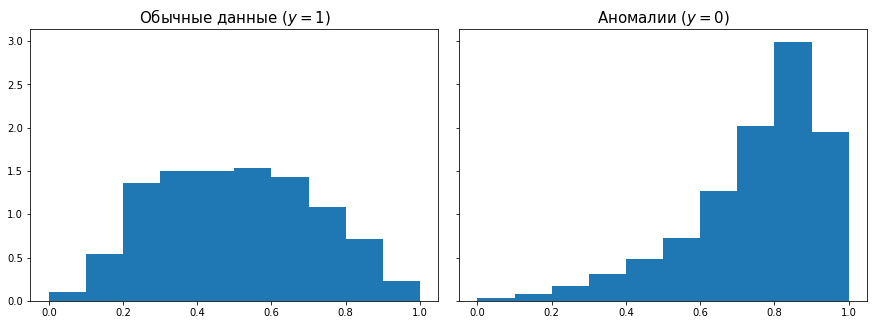

In [224]:
fig, axes = plt.subplots(1, 2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(15)
axes[0].hist(np.concatenate(X[np.where(y == 1)]), label='$y=1$', density=True)
axes[0].set_title('Обычные данные ($y=1$)', fontsize=15)
axes[1].hist(np.concatenate(X[np.where(y == 0)]), label='$y=0$', density=True)
axes[1].set_title('Аномалии ($y=0$)', fontsize=15)
plt.subplots_adjust(wspace=0.05)

In [212]:
df = pd.read_csv('test_groups.csv')
groups = df.groupby('group_id')
global_index = 0
count = 0
X_test = np.empty((df.shape[0], 20), dtype=float)
for group_id, group_index in groups.groups.items():
    size_of_group = group_index.size
    group = (df.iloc[group_index])
    for index, distances in enumerate(pairwise_distances(doc_tfidf[group.doc_id], metric='cosine')):
        X_test[global_index + index] = sorted(distances)[1:21]
    global_index += size_of_group
X_test.shape

(16627, 20)

### Train model

In [213]:
scaler = StandardScaler()

In [214]:
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [218]:
param_grid_XGB = {'learning_rate': [.01, .03, .05, .1, .25],
                  'max_depth': [1, 2, 4, 6, 8, 10],
                  'n_estimators': [10, 50, 100, 300],
                  'seed': [0]}

xgb = XGBClassifier()

grid_search_xgb = GridSearchCV(xgb, param_grid_XGB, scoring=make_scorer(f1_score), cv=GroupKFold(
    n_splits=5))

grid_search_xgb.fit(X_train_scaled, y, groups=groups_train)

xgb_best = grid_search_xgb.best_estimator_

grid_search_xgb.best_params_

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:43] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:43] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:43] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:43] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:17:48] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:48] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:49] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:49] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:18:07] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:08] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:09] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:12] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:18:57] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:19:05] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:19:05] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:19:06] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:19:59] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:00] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:02] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:03] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:21:00] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:00] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:01] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:01] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:21:13] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:15] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:16] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:18] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:21:42] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:42] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:43] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:44] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:22:23] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:25] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:27] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:29] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:23:32] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:39] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:47] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:54] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:24:08] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:08] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:08] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:08] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:24:25] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:25] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:27] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:28] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:25:08] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:14] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:20] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:25] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:26:28] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:28] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:28] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:29] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:27:34] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:34] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:34] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:34] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:27:45] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:45] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:47] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:49] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:28:19] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:19] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:19] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:20] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:28:57] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:58] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:59] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:00] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:29:55] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:57] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:00] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:02] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:30:47] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:48] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:48] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:48] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:31:01] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:01] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:02] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:02] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:31:29] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:31] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:33] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:34] WARNING: /tmp/pip-build-tajdlzuo/xgboo

[20:32:29] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:35] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:42] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:49] WARNING: /tmp/pip-build-tajdlzuo/xgboo

{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10, 'seed': 0}

In [219]:
cross_val_score(xgb_best, X_train_scaled, y, groups=groups_train,
                scoring=make_scorer(f1_score)).mean()

[20:34:00] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:34:00] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:34:00] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:34:00] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:34:00] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6275944268275719

In [193]:
cross_val_score(xgb_best, X_train_scaled, y, groups=groups_train,
                scoring=make_scorer(f1_score)).mean()

/home/dmitry/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:27:18] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:27:18] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:27:18] WARNING: /tmp/pip-build-tajdlzuo/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:27:19] WARNING: /tmp/pip-build-tajdlzuo/xgboo

0.6348130357970494

In [194]:
def submit(clf):
    y_pred = clf.predict(X_test_scaled)

    y_pred = y_pred.astype(int)

    answer = pd.DataFrame({'pair_id': np.asarray(
        test_data['pair_id']), 'target': y_pred})

    answer = answer.set_index(['pair_id'])

    answer.to_csv('my_submission.csv')

In [195]:
submit(xgb_best)

In [131]:
my_s = pd.read_csv('my_submission.csv')
k_s = pd.read_csv('k_submission.csv')

In [132]:
my_s[my_s['target']==1]

,pair_id,target
5,11696,1
13,11704,1
25,11716,1
39,11730,1
40,11731,1
...,...,...
16551,28242,1
16553,28244,1
16556,28247,1
16586,28277,1


In [133]:
k_s[k_s['target']==1]

,pair_id,target
37,11728,1
56,11747,1
112,11803,1
114,11805,1
119,11810,1
...,...,...
16600,28291,1
16602,28293,1
16603,28294,1
16604,28295,1
